In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
from cycler import cycler
from math import floor

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

# Problem set-up

In [2]:
# numeric parameters of the system
m = 1.
k = 100.
c = 5.
g = 10.
h = .02

In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [0., 0., 0.]
    ])
B1 = np.array([
    [0.],
    [1.],
    [0.]
    ])
c1 = np.array([
    [0.],
    [0.],
    [-g]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.1 (paddle pushing ball)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A3 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [-k/m, k/m, -c/m]
    ])
B3 = np.array([
    [0.],
    [1.],
    [c/m]
    ])
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

In [4]:
# state bounds
x_max = np.array([
    [1.],
    [.1],
    [4.]
])
x_min = np.array([
    [-.3],
    [-.1],
    [-4.]
])
f_max = 4.*m*g


# input bounds
u_max = np.array([[.3]])
u_min = - u_max

# domain bounds
xu_min = np.vstack((x_min, u_min))
xu_max = np.vstack((x_max, u_max))

# domain n.1
# (out of contact when q_ball - q_paddle > m*g/k)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_inequality(
    np.array([[-1., 1., 0., 0.]]),
    np.array([[-m*g/k]])
)
assert D1.bounded
assert not D1.empty

# domain n.2
# (pulling when q_ball - q_paddle < m*g/k
# and f = k (qp - qb) + c (qpd - qbd) + m g < 0)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D2.add_inequality(
    np.array([[-k, k, -c, c]]),
    np.array([[-m*g]])
)
assert D2.bounded
assert not D2.empty

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_inequality( # penetration > 0
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D3.add_inequality( # not pulling
    np.array([[k, -k, c, -c]]),
    np.array([[m*g]])
)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -c, c]]),
    np.array([[f_max - m*g]])
)
assert D3.bounded
assert not D3.empty

# list of domains
D_list = [D1, D2, D3]

In [5]:
# PWA system
S = PieceWiseAffineSystem(S_list, D_list)

# controller parameters
N = 80
Q = np.diag([5.,50.,.1])
R = np.diag([10.])

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(np.zeros((3,1)),np.zeros((3,1)))

# Solve with different MI formulation

In [6]:
# initial condition
x0 = np.array([[1.], [.0], [.0]])

# MI formulations
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]

In [7]:
# solve MICP with all the methods
solves = {}
for method in methods:
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    controller.prog.setParam('OutputFlag', 0)
    u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
    solves[method] = {
        'time': controller.prog.Runtime,
        'nodes': controller.prog.NodeCount
    }
    
# print solution times and nodes
for method in methods:
    print method
    print 'Solution time:', solves[method]['time']
    print 'Explored nodes:', solves[method]['nodes']

Convex hull, lifted constraints
Solution time: 40.4963109493
Explored nodes: 2474.0


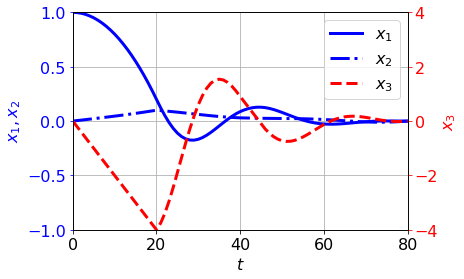

In [55]:
# plot state trajectory
plt.rc('font', size=16)
time = range(N+1)
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# position of the ball and the paddle (x1 and x3)
x1_plot = ax1.plot(time, [x_t[0,0] for x_t in x_mip], 'b-', label=r'$x_1$', linewidth=3)
x2_plot = ax1.plot(time, [x_t[1,0] for x_t in x_mip], 'b-.', label=r'$x_2$', linewidth=3)
x12_lim = max([-x_min[0,0], x_max[0,0], -x_min[1,0], x_max[1,0]])
ax1.set_ylim([-x12_lim, x12_lim])
ax1.set_ylabel(r'$x_1, x_2$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# velocity of the ball (x2)
ax2 = ax1.twinx()
x3_plot = ax2.plot(time, [x_t[2,0] for x_t in x_mip], 'r--', label=r'$x_3$', linewidth=3)
x3_lim = max([-x_min[2,0],x_max[2,0]])
ax2.set_ylim([-x3_lim, x3_lim])
ax2.set_ylabel(r'$x_3$', color='r')
ax2.tick_params('y', colors='r')

# plot
x_plot = x1_plot + x2_plot + x3_plot
labels = [xi_plot.get_label() for xi_plot in x_plot]
ax1.legend(x_plot, labels)
plt.savefig('state.pdf', bbox_inches='tight')
plt.show()

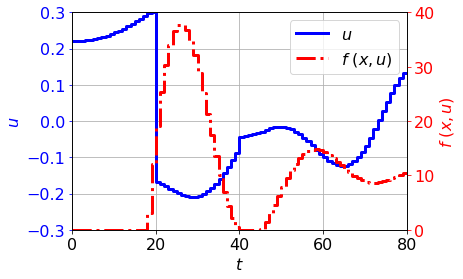

In [9]:
# plot input sequence and contact force
plt.rc('font', size=16)
f = [max(k*(x_mip[t][1,0]-x_mip[t][0,0]) + c*(u_mip[t][0,0]-x_mip[t][2,0]) + m*g, 0.) for t in range(N)]
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$t$')
ax1.set_xlim([0,N])
ax1.grid(True)

# input
u_plot = ax1.step(time, [u_mip[0][0,0]] + [u_t[0,0] for u_t in u_mip], 'b', linestyle='-', label=r'$u$', linewidth=3)
u_lim = max([-u_min[0,0], u_max[0,0]])
ax1.set_ylim([-u_lim, u_lim])
ax1.set_ylabel(r'$u$', color='b')
ax1.tick_params('y', colors='b')
plt.legend()

# force
ax2 = ax1.twinx()
f_plot = ax2.step(time, [f[0]] + [f_t for f_t in f], 'r', linestyle='-.', label=r'$f \ (x,u)$', linewidth=3)
ax2.set_ylim([0, f_max])
ax2.set_ylabel(r'$f \ (x,u)$', color='r')
ax2.tick_params('y', colors='r')

# plot
fu_plot = u_plot + f_plot
labels = [fui_plot.get_label() for fui_plot in fu_plot]
ax1.legend(fu_plot, labels)
# plt.savefig('input_force.pdf', bbox_inches='tight')
plt.show()

# Integer feasibility and suboptimality

In [175]:
def closest_binary_assignment(d, x0):
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Convex hull')
    new_obj = 0.
    for t, dt in enumerate(d):
        for k, dtk in enumerate(dt):
            dtk_var = controller.prog.getVarByName('d%d[%d]'%(t,k))
            new_obj += (dtk_var - dtk)*(dtk_var - dtk)
    controller.prog.setObjective(new_obj)
    opt_sol = controller.feedforward(x0)
    return opt_sol[2], opt_sol[4]

In [181]:
def dist_sq(l1, l2):
    assert len(l1) == len(l2)
    return sum([(l2[i] - e1)**2. for i, e1 in enumerate(l1)])

def dist(l1, l2):
    l1_array = np.array([l1ij for l1i in l1 for l1ij in l1i])
    l2_array = np.array([l2ij for l2i in l2 for l2ij in l2i])
    return np.linalg.norm(l1_array - l2_array)
    
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Convex hull, lifted constraints')
u, x, ms, cost, d = controller.feedforward_relaxation(x0, ms_mip[:0])
# d_rounded = [[1 if i == ms[t] else 0 for i in range(S.nm)] for t in range(N)]

ms_feasible, d_feasible = closest_binary_assignment(d, x0)
# integer_feasibility = sum([dist_sq(d[t], d_feasible_mip[t]) for t in range(N)])
# integer_feasibility = sum([min([dist_sq(dt, ba) for ba in [[1,0,0],[0,1,0],[0,0,1]]]) for dt in d])
integer_feasibility = dist(d, d_feasible)

cost_integer_feasible = controller.feedforward_relaxation(x0, ms_feasible)[3]

d_mip = [[1 if i == ms_mip[t] else 0 for i in range(S.nm)] for t in range(N)]
# integer_optimality = sum([dist_sq(d[t], d_mip[t]) for t in range(N)])
integer_optimality = dist(d, d_mip)

print integer_feasibility, integer_optimality, cost_integer_feasible/cost_mip

1.62758888736873 3.8273976991276784 1.00496730815


controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Convex hull, lifted constraints')
_, _, ms, cost, d = controller.feedforward_relaxation(x0, ms_mip[:19])
_, _, _, cost, _ = controller.feedforward_relaxation(x0, ms)
print cost
for t in range(N):
    print t, ms[t], ms_mip[t], d[t]

In [10]:
# cost of each relaxation as a function of time
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]
costs = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    costs[method] = []
    for ms in [ms_mip[:i] for i in range(N+1)]:
        ms_relaxation = controller.feedforward_relaxation(x0, ms)[2]
        cost = controller.feedforward_relaxation(x0, ms_relaxation)[3]
        if cost is not None:
            cost /= cost_mip
        costs[method].append(cost)

Traditional formulation
Big-M
Convex hull
Convex hull, lifted constraints


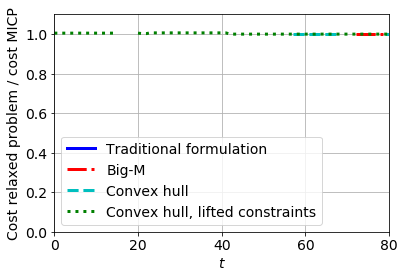

In [11]:
# plot cost of relaxed problem / cost MICP
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)
colors = ['b', 'r', 'c', 'g']
linestyles = ['-','-.','--',':']
for i, method in enumerate(methods):
    plt.plot(range(N+1), costs[method], label=method, color=colors[i], linestyle=linestyles[i], linewidth=3)
plt.xlim((0, N))
plt.ylim((0, 1.1))
plt.legend()
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'Cost relaxed problem / cost MICP')
# plt.savefig('relaxation_ratio.pdf', bbox_inches='tight')
plt.show()

# Compare formulations for different levels of relaxation

In [ ]:
# cost of each relaxation as a function of time
costs = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    costs[method] = []
    for ms in [ms_mip[:i] for i in range(N+1)]:
        cost = controller.feedforward_relaxation(x0, ms)[3]
        if cost is not None:
            cost /= cost_mip
        costs[method].append(cost)

In [ ]:
# plot cost of relaxed problem / cost MICP
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)
colors = ['b', 'r', 'c', 'g']
linestyles = ['-','-.','--',':']
for i, method in enumerate(methods):
    plt.plot(range(N+1), costs[method], label=method, color=colors[i], linestyle=linestyles[i], linewidth=3)
plt.xlim((0, N))
plt.ylim((0, 1.1))
plt.legend()
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'Cost relaxed problem / cost MICP')
# plt.savefig('relaxation_ratio.pdf', bbox_inches='tight')
plt.show()

# Objective as a function of the initial state ($x_1$ and $x_3$ only)

In [ ]:
# samples for the initial position and velocity of the ball
q_p = 0.
n_levels = 10
n_samples = 101
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)

In [ ]:
# utils for the plots

def my_round(x):
    return floor(x*10.)/10.

def get_neighbors(M, i, j):
    return [
        M[i+1, j-1],
        M[i+1,   j],
        M[i+1, j+1],
        M[  i, j+1],
        M[i-1, j+1],
        M[i-1,   j],
        M[i-1, j-1],
        M[  i, j-1]
    ]

def fill_holes_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            if np.isnan(cost_mat[i,j]):
                neighbors = get_neighbors(cost_mat, i, j)
                if not any([np.isnan(n) for n in neighbors]):
                    print 'Filled', (i,j) 
                    cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

def regularize_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            neighbors = get_neighbors(cost_mat, i, j)
            if all([cost_mat[i,j] > n for n in neighbors]):
                print 'Regularized', (i,j) 
                cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

In [ ]:
# solve relaxations for all MI formulations
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    
    # get feasible sets (uses the feasible set of the CH method for the CHLC method)
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        cs = get_constraint_set(controller.prog)
        var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
        v_index = var_indices[controller.prog.getVarByName('x0[1]')]
        A_sect = np.hstack((cs.A[:, :v_index], cs.A[:, v_index+1:]))
        b_sect = cs.b - cs.A[:, v_index:v_index+1] * q_p
        cs_sect = Polyhedron(A_sect, b_sect)
        sect = convex_hull_method_fast(cs_sect, [0,1])
        
    # samples on the grid
    cost_mat = np.empty([n_samples]*2)
    for i, q_b in enumerate(q_b_samples):
        for j, v_b in enumerate(v_b_samples):
            print(str(i) + ',' + str(j) + '   \r'),
            x0 = np.array([[q_b],[q_p],[v_b]])
            cost = controller.feedforward_relaxation(x0, [])[3]
            cost_mat[i,j] = cost
    
#     # save data
#     np.save(method + '_feasible_set_A', sect.A)
#     np.save(method + '_feasible_set_b', sect.b)
#     np.save(method, cost_mat)

In [ ]:
# plot cost and feasible set
plt.rc('font', size=14)
for method in methods:
    cost_mat = np.load(method + '.npy')
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        A = np.load(method + '_feasible_set_A.npy')
        b = np.load(method + '_feasible_set_b.npy')
        sect = Polyhedron(A, b)
    levels = [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
    cp = plt.contour(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
    plt.colorbar(cp, label='Cost relaxed problem')
    sect.plot(facecolor='w')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_3$')
    plt.title(method)
    plt.grid(True)
#     plt.savefig(method + '.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
# solve MICP on the grid (COMMENT prog.reset() BEFORE RUNNING THIS!!!)
cost_mat = np.empty([n_samples]*2)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Big-M')
controller.prog.setParam('OutputFlag', 0)
controller.prog.setParam('MIPGap', 0.01)
controller.prog.setParam('TimeLimit', 1200.)
time_limits = 0
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + ',' + str(time_limits) + '    \r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward(x0)[3]
        cost_mat[i,j] = cost
        if controller.prog.status == 9:
            time_limits += 1
            
# # save data
# np.save('q_b_samples', q_b_samples)
# np.save('v_b_samples', v_b_samples)
# np.save('cost_mat_miqp', cost_mat)

In [ ]:
# plot cost MICP
plt.rc('font', size=14)
cost_mat = np.load('cost_mat_miqp.npy')
cost_mat = fill_holes_cost_mat(cost_mat)
cost_mat = regularize_cost_mat(cost_mat)
n_levels = 9
levels = [0.] + [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
cp = plt.contourf(Q_b, V_b, cost_mat.T, levels=levels, cmap='viridis_r')
plt.grid(True)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='Cost MICP')
plt.grid(True)
# plt.savefig('cost_mat_miqp.pdf',bbox_inches='tight')
plt.show()